**Simple Moving Average Model**

In [23]:
# Import packages and clean up data

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/appl_stock_values.csv", index_col = 0, header=0)
df["Date"] = pd.to_datetime(df["Date"])
del df["Open"]
del df["High"]
del df["Low"]
del df["Volume"]
df["Date Copy"] = df["Date"]
df = df.set_index("Date")
df


,Close,Date Copy
Date,,
1984-09-07,0.423880,1984-09-07
1984-09-10,0.421340,1984-09-10
1984-09-11,0.429020,1984-09-11
1984-09-12,0.416180,1984-09-12
1984-09-13,0.439270,1984-09-13
...,...,...
2021-12-16,172.259995,2021-12-16
2021-12-17,171.139999,2021-12-17
2021-12-20,169.750000,2021-12-20


In [10]:
# Assess whether the data is stationary
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df["Close"])
print(f'ADF Stat: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Stat: -0.086841374934165
p-value: 0.9507335132146989


Thus, this data set is not stationary, so we need to transform it into a stationary data set

In [11]:
# Apply first order differencing to make it stationary

import numpy as np

stock_close_diff = np.diff(df["Close"], n = 1)

ADF_result = adfuller(stock_close_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -41.23692623760103
p-value: 0.0


Now we have made the data stationary. Now we can apply the ACF Function to find the parameters for the MA model

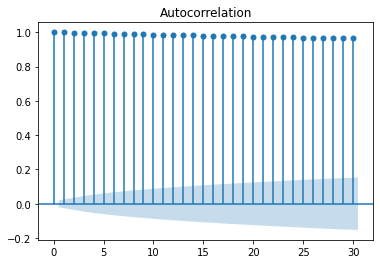

In [12]:
# Plot the ACF graph

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Close"], lags= 30)
plt.show()

Lags 0 - 10 are all outside of the shaded region and positive correlation, thus lags 0 - 10 are all considered as significant coefficients. So, we have significant coefficients for all lags 0 - 10; so we create a moving average model with order 10. 

In [13]:
# Implement the moving average model

from statsmodels.tsa.arima.model import ARIMA

# MA_model uses the ARIMA function but set the parameters p and d to 0. Set the q (lag) value to 10 as identified in ACF plot.
MA_model = ARIMA(endog = df["Close"], order = (0,0,10)) 
results = MA_model.fit()
print(results.summary())

/Users/kevinkim/Projects/venv_kevin/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kevinkim/Projects/venv_kevin/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kevinkim/Projects/venv_kevin/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kevinkim/Projects/venv_kevin/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximu

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 9397
Model:                ARIMA(0, 0, 10)   Log Likelihood              -27999.910
Date:                Fri, 24 Dec 2021   AIC                          56023.820
Time:                        22:50:56   BIC                          56109.597
Sample:                             0   HQIC                         56052.945
                               - 9397                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.8668      0.928     31.113      0.000      27.048      30.685
ma.L1          1.1835      0.003    449.770      0.000       1.178       1.189
ma.L2          1.6413      0.004    412.927      0.0

In [32]:
import datetime

df["Forecast"] = results.predict(start = "2021-01-04", end = "2021-12-22")
df

,Close,Date Copy,Forecast
Date,,,
1984-09-07,0.423880,1984-09-07,NaN
1984-09-10,0.421340,1984-09-10,NaN
1984-09-11,0.429020,1984-09-11,NaN
1984-09-12,0.416180,1984-09-12,NaN
1984-09-13,0.439270,1984-09-13,NaN
...,...,...,...
2021-12-16,172.259995,2021-12-16,174.247064
2021-12-17,171.139999,2021-12-17,162.681362
2021-12-20,169.750000,2021-12-20,157.401003


<AxesSubplot:xlabel='Date'>

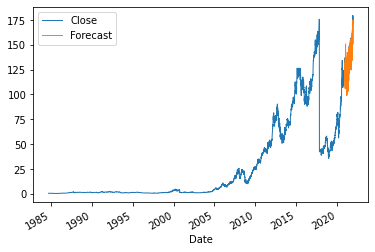

In [26]:
df[["Close", "Forecast"]].plot(lw = 1)

In [35]:
#The graph looks pretty good but lets look at the error value up close
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

mean_squared_error(df[df["Date Copy"] >= datetime.datetime(2021, 1, 4)]["Forecast"].values.tolist(), df[df["Date Copy"] >= datetime.datetime(2021, 1, 4)]["Close"].values.tolist())
mean_absolute_percentage_error(df[df["Date Copy"] >= datetime.datetime(2021, 1, 4)]["Forecast"].values.tolist(), df[df["Date Copy"] >= datetime.datetime(2021, 1, 4)]["Close"].values.tolist())

0.0702521569192981